# NIST Scrape 
Starting from this work:

1) https://pubs.acs.org/doi/pdf/10.1021/acs.analchem.1c00867

2) https://github.com/Ohio-State-Allen-Lab/FTIRMachineLearning

3) https://www.linkedin.com/pulse/unofficial-nist-webbook-api-how-get-thermochemistry-data-contreras/?trk=pulse-article_more-articles_related-content-card

4) https://github.com/oscarcontrerasnavas/nist-webbook-API

5) https://github.com/nzhagen/jcamp
      RUN IN COMMAND LINE: 1 ) python -m pip install git+https://github.com/nzhagen/jcamp

My work stored here: 

https://github.com/kevinpatrickkent/FTIRMachineLearning/

In [71]:
# Kevin Patrick Kent
# updated from original code at https://github.com/Ohio-State-Allen-Lab/FTIRMachineLearning

import os
import requests, urllib
import argparse
import logging
import pandas as pd 
import jcamp #Planning to use this later to import all of the .jdx files
import matplotlib.pyplot as plt
import numpy as np
import pickle
from scipy import interpolate
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
#from model.utils import set_logger
# Was not able to run this on the first runthrough.  Will try this again later after investigation but continuing for now.

In [2]:
nist_url = "https://webbook.nist.gov/cgi/cbook.cgi"

# Get Dataframe of all Molecules in NIST Webbook

Used webbook API from here: https://github.com/oscarcontrerasnavas/nist-webbook-API

In [3]:
# I chose 40000 here because there are currently 37495 molecules on webbook

# Perform an inital query to see how many items are present in the database
url = 'https://nist-api.fly.dev/substances?page=1&per_page=10'
response = requests.get(url)
json = response.json()
tot = json['totalItems'] #Get the total number of items and store it for the next request

url = 'https://nist-api.fly.dev/substances?page=1&per_page=' + str(tot+1000)
response = requests.get(url) 
json = response.json()
df = pd.DataFrame(json['items'])
df.head()

# Here I'm making the cas the index for easy referencing

df.set_index('cas', inplace = True)

# Define Function for Scraping the IR Spectra from Webbook

Used the function from here: https://github.com/Ohio-State-Allen-Lab/FTIRMachineLearning

In [4]:
def scrape_data(cas_ls, params, data_dir):
	'''Collect data from NIST database and store them in jdx format.
    Args:
        cas_ls: (list) CAS ids to download data for
		params: (dict) queries to be added to url
		data_dir: (string) path to store the data
    Returns:
        None
    '''	
    
    #Create directory for the relevant spetra 
	spectra_path = os.path.join(data_dir, params['Type'].lower(), '')
	if not os.path.exists(spectra_path):
		os.makedirs(spectra_path)

	num_created = 0
	for cas_id in cas_ls:
		params['JCAMP'] = 'C' + cas_id
		response = requests.get(nist_url, params=params)

		if response.text == '##TITLE=Spectrum not found.\n##END=\n':
			continue
		num_created+=1
		logging.info('Creating {} spectra for id: {}. Total spectra created {}'.format(params['Type'].lower(), cas_id, num_created))
		with open(spectra_path +cas_id +'.jdx', 'wb') as data:
			data.write(response.content)

<b> Note that I ran this once and then just worked from the downloaded .jdx files.

In [ ]:
# Do not run this each time as it takes several hours to download these spectra

#Create data directory to store logs and spectra
data_dir = './data'
if not os.path.exists(data_dir):
	os.makedirs(data_dir)

logging.info('Scrape IR spectra')
# Taking this out because I'm running from the command line
#if args.scrap_IR:
cas_ids = df.cas
params={'JCAMP': '', 'Type': 'IR', 'Index': 0}	
scrape_data(cas_ids, params, data_dir)

# Pull in All of the Data from the JCAMP files with jcamp

https://github.com/nzhagen/jcamp 

Text(0, 0.5, 'TRANSMITTANCE')

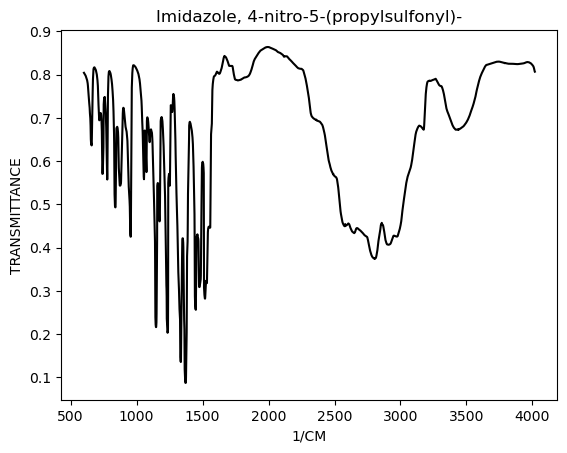

In [5]:
# Making sure I'm able to get the data with the jcamp module

path = 'C:\\Users\\kevin\\Documents\\Python Scripts\\data\\ir\\'
cas = 99980286
data = jcamp.jcamp_readfile(path + str(cas) + '.jdx')

plt.figure()
plt.plot(data['x'], data['y'], color = 'black')
plt.title(data['title'])
plt.xlabel(data['xunits'])
plt.ylabel(data['yunits'])

In [6]:
data

{'title': 'Imidazole, 4-nitro-5-(propylsulfonyl)-',
 'jcamp-dx': 4.24,
 'data type': 'INFRARED SPECTRUM',
 'class': 'COBLENTZ III',
 'origin': 'SOUTHERN RESEARCH INSTITUTE',
 'owner': 'Copyright (C) 1987 by the Coblentz Society\nCollection (C) 2018 copyright by the U.S. Secretary of Commerce\non behalf of the United States of America. All rights reserved.',
 'date': '1959/11/23',
 'names': '4-nitro-5-(propylsulfonyl)-1H-imidazole\n4-nitro-1H-imidazol-5-yl propyl sulfone',
 'cas registry no': '99980-28-6',
 'molform': 'C6 H9 N3 O4 S',
 'source reference': 'COBLENTZ NO. 7840',
 '$nist source': 'COBLENTZ',
 '$nist image': 'cob7840',
 'spectrometer/data system': 'PERKIN-ELMER 21 (GRATING)',
 'instrument parameters': 'FILTER CHANGE ABOUT 1025 CM^-^1',
 'state': 'SOLID (1 mg / 650 mg KBr DISC)',
 'sampling procedure': 'TRANSMISSION',
 'resolution': 2,
 'data processing': 'DIGITIZED BY COBLENTZ SOCIETY (BATCH II) FROM HARD COPY (ADJUSTED \\addcm-1\\20-10-2\\)',
 'xunits': '1/CM',
 'yunits': '

In [7]:
## Here I'm just going through my strategy for one jcamp before looping through all of them
# Setting the dict that I'll be adding all of the spectra to

spec_dict = {'cas':[], 'x':[], 'y':[]}
spec_dict['cas'].append(str(cas))
spec_dict['x'].append(data['x'])
spec_dict['y'].append(data['y'])

print(spec_dict)

# Then I will drop the spectra from the jcamp dict

del data['x']
del data['y']

meta_dict = {'cas':[str(cas)]}
for key in data:
    meta_dict[key] = [data[key]]

print(meta_dict)



{'cas': ['99980286'], 'x': [array([ 601.565714 ,  602.5699556,  603.5741972, ..., 4015.987275 ,
       4016.9936375, 4018.       ])], 'y': [array([0.8043, 0.8036, 0.8032, ..., 0.8088, 0.8075, 0.8069])]}
{'cas': ['99980286'], 'title': ['Imidazole, 4-nitro-5-(propylsulfonyl)-'], 'jcamp-dx': [4.24], 'data type': ['INFRARED SPECTRUM'], 'class': ['COBLENTZ III'], 'origin': ['SOUTHERN RESEARCH INSTITUTE'], 'owner': ['Copyright (C) 1987 by the Coblentz Society\nCollection (C) 2018 copyright by the U.S. Secretary of Commerce\non behalf of the United States of America. All rights reserved.'], 'date': ['1959/11/23'], 'names': ['4-nitro-5-(propylsulfonyl)-1H-imidazole\n4-nitro-1H-imidazol-5-yl propyl sulfone'], 'cas registry no': ['99980-28-6'], 'molform': ['C6 H9 N3 O4 S'], 'source reference': ['COBLENTZ NO. 7840'], '$nist source': ['COBLENTZ'], '$nist image': ['cob7840'], 'spectrometer/data system': ['PERKIN-ELMER 21 (GRATING)'], 'instrument parameters': ['FILTER CHANGE ABOUT 1025 CM^-^1'], 'st

In [ ]:
# This is another to not run everytime.

path = 'C:\\Users\\kevin\\Documents\\Python Scripts\\data\\ir\\'
spec_dict = {'cas':[], 'x':[], 'y':[]}
meta_keys = ['cas', 'title', 'jcamp-dx', 'data type', 'origin', 'owner', 'cas registry no', 'molform', '$nist source', 'state', 'xunits', 'yunits', 'xfactor', 'yfactor', 'deltax', 'firstx', 'lastx', 'firsty', 'maxx', 'minx', 'maxy', 'miny', 'npoints', 'xydata', 'end', 'filename', 'date', '$nist doc file', '$nist psd file', 'spectrometer/data system', 'aperture', 'external diffuse reflectance accessory', 'beamsplitter', 'detector (dia. det. port in sphere)', 'sphere diameter', 'acquisition mode', 'scanner speed', 'coadded scans', 'phase resolution', 'phase correction', 'zerofilling', 'spectral range', 'resolution', 'spectral resolution', 'wavenumber accuracy', 'apodization function', 'low pass filter', 'switch gain on', 'xlabel', 'ylabel', 'class', 'source reference', '$nist image', 'sampling procedure', 'data processing', 'instrument parameters', 'names', 'path length', 'bp', 'instrument resolution', 'ir source', 'detector', 'interferogram zerofill', 'spectral interval after zerofilling', 'apodization', 'folding limits', 'number of interferograms averaged per single channel spectrum', 'mp', 'cas name', 'sample description', 'temperature', '$spectra version', '$uncertainty in y', 'pressure', '$nist id']
meta_dict = {}
for key in meta_keys:
    meta_dict[key] = []
IRSpecCount = 0
NoIRSpecCount = 0

for cas in df.index:
    try:
        data = jcamp.jcamp_readfile(path + cas + '.jdx')
        IRSpecCount += 1
    except:
        NoIRSpecCount += 1
        continue
    
    spec_dict['cas'].append(cas)
    spec_dict['x'].append(data['x'])
    
    spec_dict['y'].append(data['y'])
    del data['x']
    del data['y']
    
    for key in meta_dict:
        if key in data:
            meta_dict[key].append(data[key])
        elif key == 'cas':
            meta_dict[key].append(cas)
        else:
            meta_dict[key].append(np.NaN)

print('This many compounds have IR Spectra:', IRSpecCount)
print('This many compounds have do not have IR Spectra:', NoIRSpecCount)

In [ ]:
# Not running this one because I didn't load this time.

meta_df = pd.DataFrame.from_dict(meta_dict)
meta_df.set_index('cas', inplace = True)

meta_df.head()

In [ ]:
#Not running this one because I didn't load this time.
#Just outputting the data so that I can avoid loading all of this again.

meta_df.to_csv('meta_df.csv')

pickle.dump( spec_dict, open( "spec_dict.p", "wb" ) )

In [8]:
# Need to add in a load function right here so that I can skip the part above.
# Alright there we go picking up from here.  Will need to come back and make this less clunky.
# Maybe I'll just have a whole section of 'run this once' type of code

meta_df = pd.read_csv('meta_df.csv')
meta_df.loc[:,'cas'] = meta_df.loc[:,'cas'].astype(str) #Had to set this line because pandas made cas an int64
meta_df.set_index('cas', inplace = True)

spec_dict = pd.read_pickle('spec_dict.p')

C:\Users\kevin\AppData\Local\Temp\ipykernel_18544\585516734.py:5: DtypeWarning: Columns (27,28,30,31,32,33,34,35,36,39,41,42,43,44,45,46,47,59,60,61,62,63,64,65,66,69,70,72,73,74) have mixed types. Specify dtype option on import or set low_memory=False.
  meta_df = pd.read_csv('meta_df.csv')


In [9]:
# Now merging the spectral data into the original NIST Webbook Database

df = df.join(meta_df)

df.head()

,name,formula,molecular_weight,image,title,jcamp-dx,data type,origin,owner,cas registry no,...,folding limits,number of interferograms averaged per single channel spectrum,mp,cas name,sample description,temperature,$spectra version,$uncertainty in y,pressure,$nist id
cas,,,,,,,,,,,,,,,,,,,,,
74828,methane,CH4,16.0425,https://webbook.nist.gov/cgi/cbook.cgi?Struct=...,Methane,4.24,INFRARED SPECTRUM,Sadtler Research Labs Under US-EPA Contract,NIST Standard Reference Data Program\nCollecti...,74-82-8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58855,biotin,C10H16N2O3S,244.3110,https://webbook.nist.gov/cgi/cbook.cgi?Struct=...,Biotin,4.24,INFRARED SPECTRUM,Pacific Northwest National Laboratory Under IA...,Public domain,58-85-5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
625081,"butanoic acid, 3-hydroxy-3-methyl-",C5H10O3,118.1311,https://webbook.nist.gov/cgi/cbook.cgi?Struct=...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1314916,lead telluride,PbTe,334.8000,https://webbook.nist.gov/cgi/cbook.cgi?Struct=...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16853740,ditungsten zirconium octaoxide,O8W2Zr,586.9000,https://webbook.nist.gov/cgi/cbook.cgi?Struct=...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Dropping the rows without any IR spectral data

print('Here is how many rows will be dropped (consistent with above):', df['title'].isna().sum())

df = df.drop(labels = df.loc[df['title'].isna(),:].index.tolist())

Here is how many rows will be dropped (consistent with above): 23659


# Data Exploration and Cleaning

In [11]:
df.columns

Index(['name', 'formula', 'molecular_weight', 'image', 'title', 'jcamp-dx',
       'data type', 'origin', 'owner', 'cas registry no', 'molform',
       '$nist source', 'state', 'xunits', 'yunits', 'xfactor', 'yfactor',
       'deltax', 'firstx', 'lastx', 'firsty', 'maxx', 'minx', 'maxy', 'miny',
       'npoints', 'xydata', 'end', 'filename', 'date', '$nist doc file',
       '$nist psd file', 'spectrometer/data system', 'aperture',
       'external diffuse reflectance accessory', 'beamsplitter',
       'detector (dia. det. port in sphere)', 'sphere diameter',
       'acquisition mode', 'scanner speed', 'coadded scans',
       'phase resolution', 'phase correction', 'zerofilling', 'spectral range',
       'resolution', 'spectral resolution', 'wavenumber accuracy',
       'apodization function', 'low pass filter', 'switch gain on', 'xlabel',
       'ylabel', 'class', 'source reference', '$nist image',
       'sampling procedure', 'data processing', 'instrument parameters',
       'names',

In [12]:
# Here I'm going to need to decide what to work on for the project.  Start with gas spectra likely as the largest sample size

#set this to count it as False if the state was empty - may come back to this later
gas = df.state.str.lower().str.contains('gas', na = False)

print(df.state.value_counts()[df.state.value_counts()>8])


gas                                                            8183
SOLID (MINERAL OIL MULL)                                        417
LIQUID                                                          413
LIQUID (NEAT)                                                   337
SOLID (KBr PELLET)                                              300
                                                               ... 
SOLID (1 mg / 200 mg KBr DISC) VS KBr                             9
liquid                                                            9
SOLID (KCl DISC) VS KCl                                           9
SOLUTION (10% CCl4 FOR 2.5-7.5, 10% CS2 FOR 7.5-16 MICRONS)       9
SOLUTION (10% CCl4 FOR 2.5-7.5, 10% CS2 FOR 7.5-15 MICRON)        9
Name: state, Length: 67, dtype: int64


In [13]:
# Here is something interesting.  There are 809 unlabelled states. Will have to come back to this later.
# This bumped up to 810... Hmmm some other problem in the load

df.state.isna().sum()

810

In [14]:
# What are all of our states that contain gas?

df.loc[gas,:].state.value_counts()

gas                                                                     8183
GAS (100 mmHg, N2 ADDED, TOTAL PRESSURE 600 mmHg)                          9
GAS (50 mmHg, N2 ADDED, TOTAL PRESSURE 600 mmHg)                           8
GAS                                                                        6
GAS (80 mmHg, N2 ADDED, TOTAL PRESSURE 600 mmHg)                           2
GAS (100 mmHg DILUTED TO A TOTAL PRESSURE OF 600 mmHg WITH N2)             2
GAS (200 mmHg DILUTED TO A TOTAL PRESSURE OF 600 mmHg WITH N2)             2
GAS (10 mmHg, N2 ADDED, TOTAL PRESSURE 600 mmHg)                           2
GAS (600 mmHg DILUTED TO A TOTAL PRESSURE OF 600 mmHg WITH N2)             2
GAS (60 mmHg, N2 ADDED, TOTAL PRESSURE 600 mmHg)                           2
GAS (40 mmHg, N2 ADDED, TOTAL PRESSURE 600 mmHg)                           1
GAS (150 mmHg, N2 ADDED, TOTAL PRESSURE 600 mmHg)                          1
GAS (106 mmHg, N2 ADDED, TOTAL PRESSURE 600 mmHg)                          1

In [15]:
# Defining a new column called clean_state.  I'm going to relabel all of the gas labels above as 'gas'

df['clean_state'] = np.NaN
df.loc[gas,'clean_state'] = 'gas'

In [16]:
# Now check to make sure I did that right
# Will have to do something similar with liquid, solid and solution

df.loc[gas,:].clean_state.value_counts()

gas    8239
Name: clean_state, dtype: int64

In [17]:
# What are the units for y?  All the same? Close one is in extinction coefficient units but if I normalize that won't matter
# With the transmittance spectra I need to convert to absorbance

df.loc[gas,:].yunits.value_counts()

ABSORBANCE                       8183
TRANSMITTANCE                      55
(micromol/mol)-1m-1 (base 10)       1
Name: yunits, dtype: int64

In [18]:
df.loc[gas,'xydata'].value_counts()

(X++(Y..Y))    8239
Name: xydata, dtype: int64

In [19]:
# What about x?  I need to convert micrometers to wavenumbers.  The cm-1 is the same as 1/cm (wavenumbers)

df.loc[gas,:].xunits.value_counts()

1/CM           8230
MICROMETERS       8
cm-1              1
Name: xunits, dtype: int64

In [20]:
# Just quickly fixing the cm-1

quick_cm = (df.loc[gas,:].xunits == 'cm-1').tolist()

df.loc['354336','xunits'] = '1/CM'

df.loc[gas,:].loc[quick_cm,'xunits']


cas
354336    1/CM
Name: xunits, dtype: object

In [21]:
# Check to see if it's fixed.

df.loc[gas,:].xunits.value_counts()

1/CM           8231
MICROMETERS       8
Name: xunits, dtype: int64

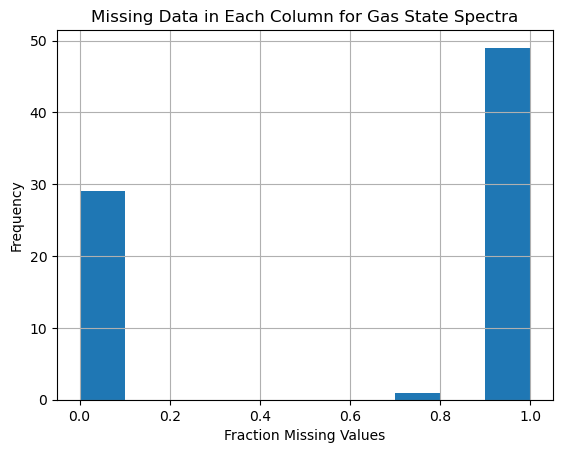

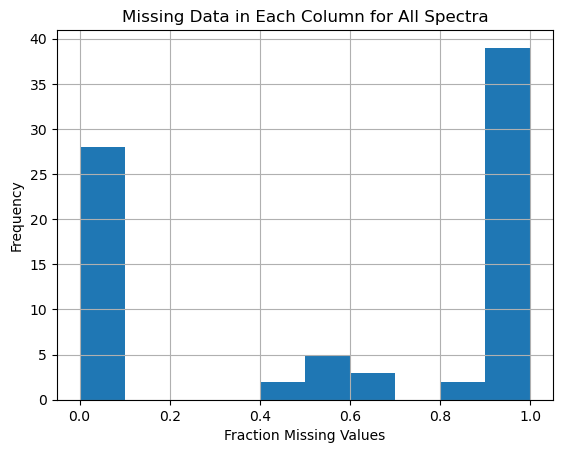

In [22]:
# How many NaNs?  Need to look into this a bit further - probably several columns I can just drop
# Focussing on gas spectra right now to get a good intermediate product.  However, there are columns
# that appear to be more important for other states (solid, solution, liquid).  Will need to investigate
# other states prior to dropping columns.

ax = (df.loc[gas,:].isna().sum()/df.loc[gas,:].shape[0]).hist()
ax.set_xlabel('Fraction Missing Values')
ax.set_ylabel('Frequency')
ax.set_title('Missing Data in Each Column for Gas State Spectra')
plt.show()

ax = (df.isna().sum()/df.shape[0]).hist()
ax.set_xlabel('Fraction Missing Values')
ax.set_ylabel('Frequency')
ax.set_title('Missing Data in Each Column for All Spectra')
plt.show()

In [23]:
# Getting a quick look at the columns so I can choose which ones to convert from wavelenght to wavenumber

df.columns

Index(['name', 'formula', 'molecular_weight', 'image', 'title', 'jcamp-dx',
       'data type', 'origin', 'owner', 'cas registry no', 'molform',
       '$nist source', 'state', 'xunits', 'yunits', 'xfactor', 'yfactor',
       'deltax', 'firstx', 'lastx', 'firsty', 'maxx', 'minx', 'maxy', 'miny',
       'npoints', 'xydata', 'end', 'filename', 'date', '$nist doc file',
       '$nist psd file', 'spectrometer/data system', 'aperture',
       'external diffuse reflectance accessory', 'beamsplitter',
       'detector (dia. det. port in sphere)', 'sphere diameter',
       'acquisition mode', 'scanner speed', 'coadded scans',
       'phase resolution', 'phase correction', 'zerofilling', 'spectral range',
       'resolution', 'spectral resolution', 'wavenumber accuracy',
       'apodization function', 'low pass filter', 'switch gain on', 'xlabel',
       'ylabel', 'class', 'source reference', '$nist image',
       'sampling procedure', 'data processing', 'instrument parameters',
       'names',

In [24]:
# Next cleaning task is clear we need to convert from micrometers to 1/cm
# Conversion is wavenumber (1/CM) = 10^4 / wavelength (micrometers)

def wavenumber(wavelength):
    ''' Simple function to convert from wavelength in micrometers to wavenumber is inverse centimeter.'''
    return (10**4)/wavelength

In [25]:
# In order to make this conversion we need to do the following.
# 1) Convert the meta data that will be used in wavenumbers (several items).
# 2) Convert the x-values for the spectra to wavenumbers.
# 3) Setup wavelength flag so that I can know which rows were changed

df.loc[:,'orig_xunits'] = np.NaN # Set up a flag so that I know when I've made the conversion
# I added the above beause the deltax is only meaningful in the original units - there is not an
# easy conversion because it depends on the wavelength.  I'm going to keep the deltax
# but have a flag in the data set to show which were converted.

def convert(cas):
    ''' Collecting all the conversion tasks for wavelength to wavenumber into a function.'''
    meta_mods = ['firstx', 'lastx', 'maxx', 'minx']
    for key in meta_mods:
        df.loc[cas,key] = wavenumber(df.loc[cas,key])
    
    # Find the location of the spectrum and convert x to wavenumber
    ind = spec_dict['cas'].index(cas)
    spec_dict['x'][ind] = wavenumber(spec_dict['x'][ind])
    
    # Lastly change the unit to the new unit
    df.loc[cas,'orig_xunits'] = df.loc[cas,'xunits']
    df.loc[cas,'xunits'] = '1/CM'
    
    return
    

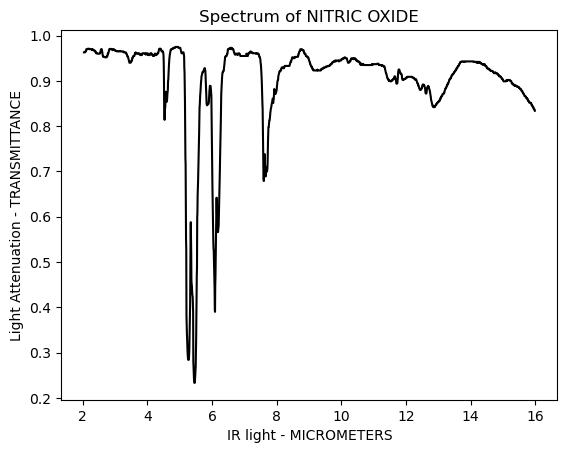

Text(0.5, 1.0, 'Check Before x-axis Conversion')

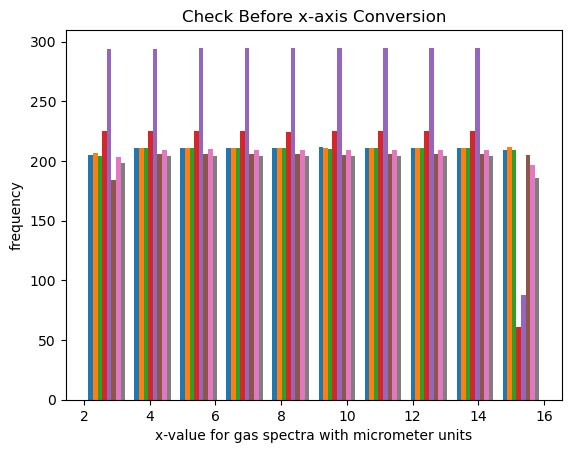

In [26]:
# Before I run this function I want to have some visualization of the x-values from spec_dict
# to make sure that I've done what I expect to do

x_check = []
microm = df.xunits.str.lower().str.contains('micrometer', na = False)

i = 0
for cas in df.loc[gas & microm,:].index:
    ind = spec_dict['cas'].index(cas)
    if i == 0:
        plt.plot(spec_dict['x'][ind], spec_dict['y'][ind], color = 'black')
        plt.xlabel('IR light - ' + df.loc[cas,'xunits'])
        plt.ylabel('Light Attenuation - ' + df.loc[cas,'yunits'])
        plt.title('Spectrum of ' + df.loc[cas,'title'])
        plt.show()
    x_check.append(spec_dict['x'][ind].tolist())
    i += 1

plt.hist(x_check)

plt.xlabel('x-value for gas spectra with micrometer units')
plt.ylabel('frequency')
  
plt.title('Check Before x-axis Conversion')
    

In [27]:
# Run the function to convert to wavenumber

for cas in df.loc[gas & microm, :].index:
    convert(cas)

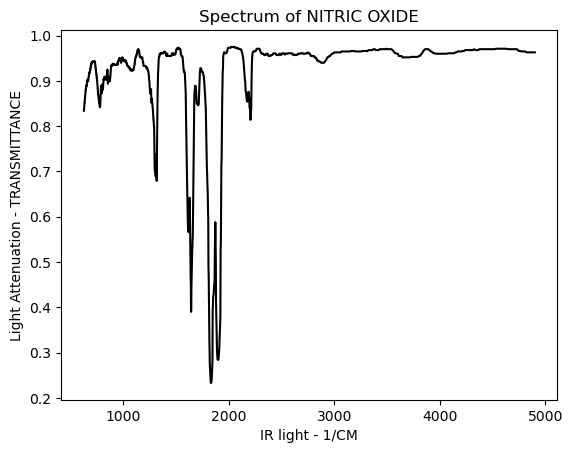

Text(0.5, 1.0, 'Check Before x-axis Conversion')

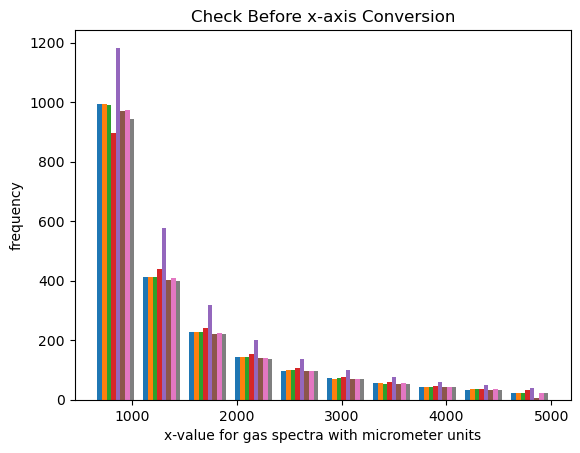

In [28]:
# Now after let's check and see how things went

x_check = []

i = 0
for cas in df.loc[gas & microm,:].index:
    ind = spec_dict['cas'].index(cas)
    if i == 0:
        plt.plot(spec_dict['x'][ind], spec_dict['y'][ind], color = 'black')
        plt.xlabel('IR light - ' + df.loc[cas,'xunits'])
        plt.ylabel('Light Attenuation - ' + df.loc[cas,'yunits'])
        plt.title('Spectrum of ' + df.loc[cas,'title'])
        plt.show()
    x_check.append(spec_dict['x'][ind].tolist())
    i += 1

plt.hist(x_check)

plt.xlabel('x-value for gas spectra with micrometer units')
plt.ylabel('frequency')
  
plt.title('Check Before x-axis Conversion')

In [29]:
# Check to see if it's fixed - Looks good only one unit present

df.loc[gas,:].xunits.value_counts()

1/CM    8239
Name: xunits, dtype: int64

In [30]:
# Check to see if my flag tells me where the inaccurate deltax are located - looks good

df.loc[gas,:].orig_xunits.value_counts()

MICROMETERS    8
Name: orig_xunits, dtype: int64

That went as expected now move on to checking on other items that may need cleaned up

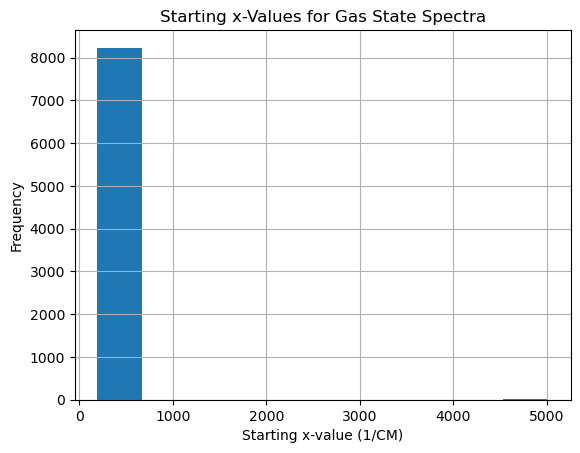

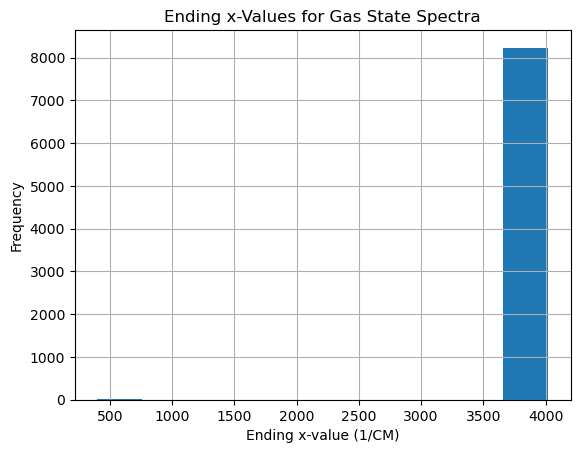

In [31]:
# Looking at histograms of the starting and ending wavenumbers for the data it's
# clear that we've got some spectra in descending order.  Need to fix that.

ax = df.loc[gas,'firstx'].hist()
ax.set_xlabel('Starting x-value (1/CM)')
ax.set_ylabel('Frequency')
ax.set_title('Starting x-Values for Gas State Spectra')
plt.show()

ax = df.loc[gas,'lastx'].hist()
ax.set_xlabel('Ending x-value (1/CM)')
ax.set_ylabel('Frequency')
ax.set_title('Ending x-Values for Gas State Spectra')
plt.show()



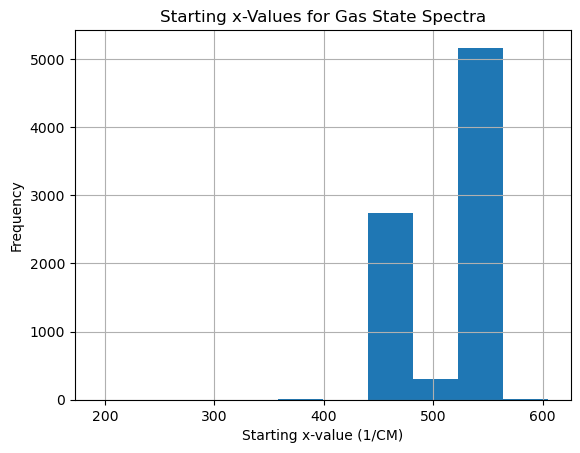

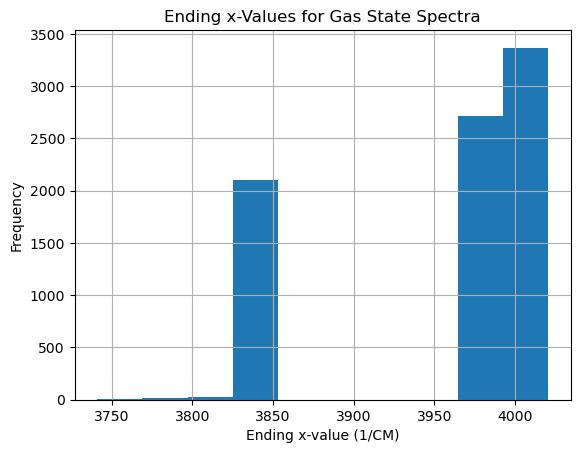

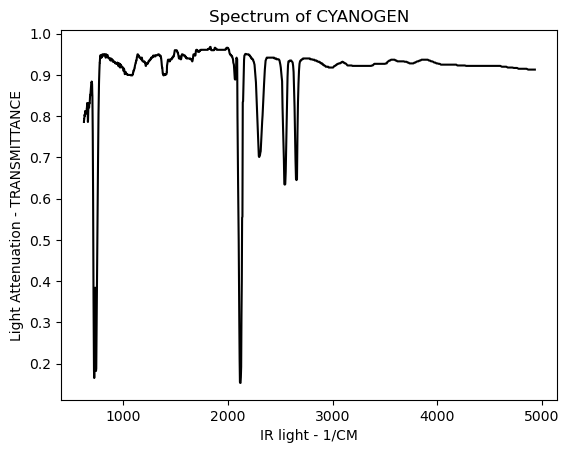

The first x-value in spec_dict for cas: 460195 is 4933.399111988159


In [32]:
# Going to do a quick investigation before I fix this.

# selecting values where the starting x is above the mid point
rev_spec = df.loc[gas,'firstx'] > 2000

# Now looking at the starting point without the reverse spectra
# OK good we can see that the distribution is narrow around
# typical starting and ending wavenumbers for IR spectra
ax = df.loc[(gas & ~rev_spec),'firstx'].hist()
ax.set_xlabel('Starting x-value (1/CM)')
ax.set_ylabel('Frequency')
ax.set_title('Starting x-Values for Gas State Spectra')
plt.show()

ax = df.loc[(gas & ~rev_spec),'lastx'].hist()
ax.set_xlabel('Ending x-value (1/CM)')
ax.set_ylabel('Frequency')
ax.set_title('Ending x-Values for Gas State Spectra')
plt.show()

# Just plotting another quick spectrum to show the spectra before transformation
# the transformation we're doing (reversing x) should have no impact on the
# spectrum.
cas = df.loc[(gas & rev_spec),:].index[1] #chose 1 so I wouldn't get nitric oxide again
ind = spec_dict['cas'].index(cas)
plt.plot(spec_dict['x'][ind], spec_dict['y'][ind], color = 'black')
plt.xlabel('IR light - ' + df.loc[cas,'xunits'])
plt.ylabel('Light Attenuation - ' + df.loc[cas,'yunits'])
plt.title('Spectrum of ' + df.loc[cas,'title'])
plt.show()
print('The first x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][0])

In [33]:
# Now go through and reverse the x and y axis

for cas in df.loc[(gas & rev_spec),:].index:
    ind = spec_dict['cas'].index(cas)
    sortind = spec_dict['x'][ind].argsort()
    spec_dict['x'][ind] = spec_dict['x'][ind][sortind]
    spec_dict['y'][ind] = spec_dict['y'][ind][sortind]
    tmp = df.loc[cas,'firstx']
    df.loc[cas,'firstx'] = df.loc[cas,'lastx']
    df.loc[cas,'lastx'] = tmp
    

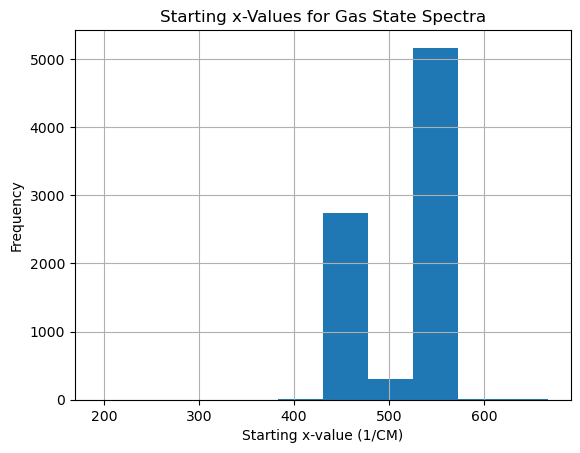

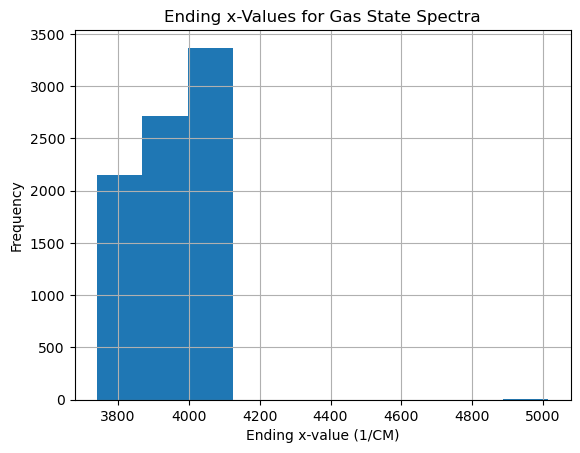

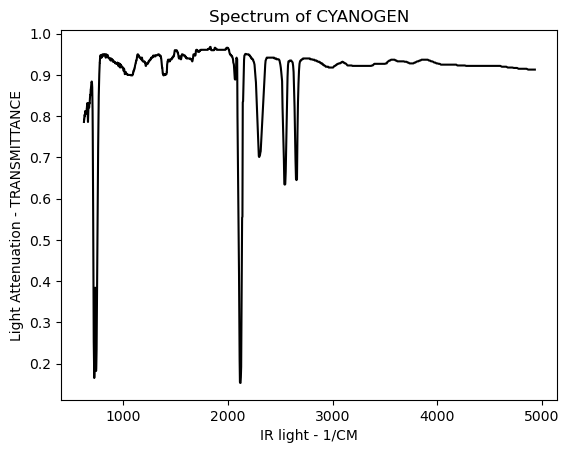

The first x-value in spec_dict for cas: 460195 is 625.0078125976574


In [34]:
# Now I'm looking at the two histograms and the spectrum again to make sure everything looks as expected

ax = df.loc[gas,'firstx'].hist()
ax.set_xlabel('Starting x-value (1/CM)')
ax.set_ylabel('Frequency')
ax.set_title('Starting x-Values for Gas State Spectra')
plt.show()

ax = df.loc[gas,'lastx'].hist()
ax.set_xlabel('Ending x-value (1/CM)')
ax.set_ylabel('Frequency')
ax.set_title('Ending x-Values for Gas State Spectra')
plt.show()

# Plot spectrum again afterwards (shouls see no difference)

cas = df.loc[(gas & rev_spec),:].index[1] #chose 1 so I wouldn't get nitric oxide again
ind = spec_dict['cas'].index(cas)
plt.plot(spec_dict['x'][ind], spec_dict['y'][ind], color = 'black')
plt.xlabel('IR light - ' + df.loc[cas,'xunits'])
plt.ylabel('Light Attenuation - ' + df.loc[cas,'yunits'])
plt.title('Spectrum of ' + df.loc[cas,'title'])
plt.show()
print('The first x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][0])

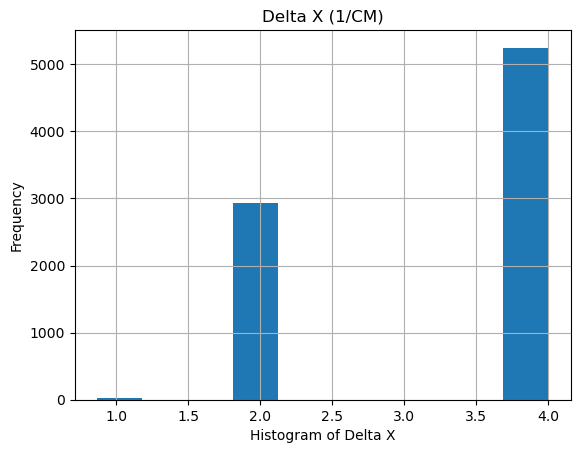

In [35]:
# Now I need to find a common axis to put all of these spectra on for analysis.
# End goal is to get all of these into a dataframe for analysis, so I need the same x-values for all of them

# Note that I'm purposefully removing the spectra in wavelength because the deltax will be off
ax = df.loc[gas & ~microm,'deltax'].hist()
ax.set_xlabel('Histogram of Delta X')
ax.set_ylabel('Frequency')
ax.set_title('Delta X (1/CM)')
plt.show()

In [36]:
# OK so four is the most common but I don't want to lose the resolution for all of those 2s... Will
# go with 2 and interpolate for 4.

two = (df.loc[gas,'deltax'] > 1.5) & (df.loc[gas,'deltax'] < 2.5)

# Now I'm looking at the two histograms again with only the deltax of 4 cm-1 spectra

print(df.loc[gas & two,'firstx'].value_counts())

print(df.loc[gas & two,'lastx'].value_counts())

549.8    2452
549.9     483
Name: firstx, dtype: int64
4000.7    2220
3999.5     483
4000.8     223
3999.2       9
Name: lastx, dtype: int64


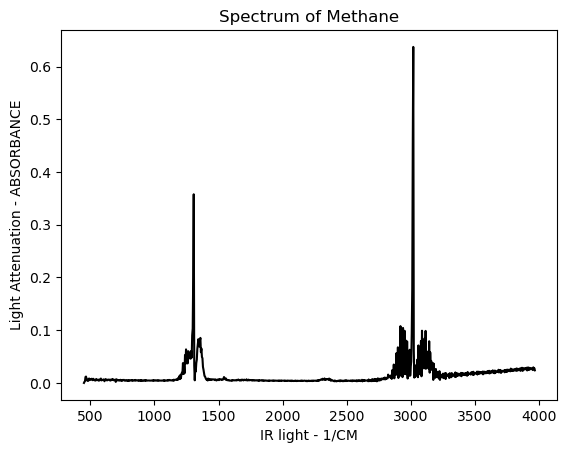

The first x-value in spec_dict for cas: 74828 is 450.0
The last x-value in spec_dict for cas: 74828 is 3966.0


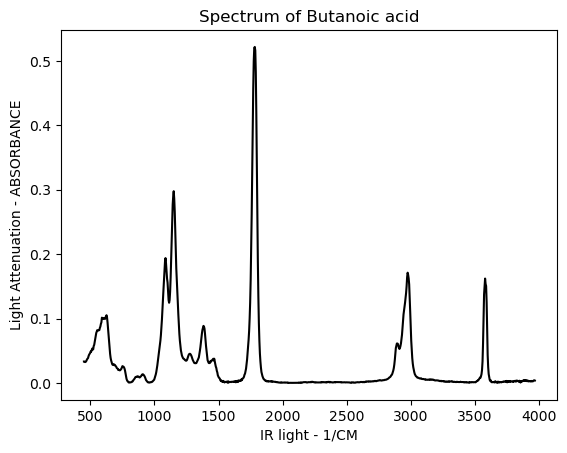

The first x-value in spec_dict for cas: 107926 is 450.0
The last x-value in spec_dict for cas: 107926 is 3966.0


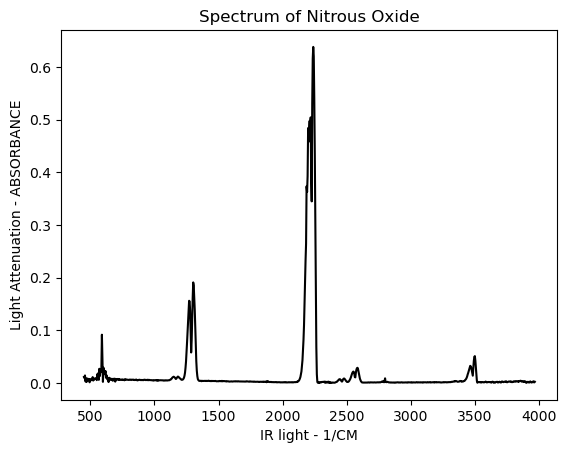

The first x-value in spec_dict for cas: 10024972 is 450.0
The last x-value in spec_dict for cas: 10024972 is 3966.0


In [37]:
# Know from previous method of analysis that deltax of four has some wider range
# spectra.  Need to pull these in order to see how the transformation impacts
# them and how much information we're losing.
# Very briefly let's get a look at what we'll be losing before a transformation

wide_range = (df.loc[gas,'deltax'] == 4) & ((df.loc[gas,'firstx'] < 550) | (df.loc[gas,'lastx'] > 3846))
sum(wide_range)

cas = df.loc[gas & wide_range, :].index[0] 
ind = spec_dict['cas'].index(cas)
plt.plot(spec_dict['x'][ind], spec_dict['y'][ind], color = 'black')
plt.xlabel('IR light - ' + df.loc[cas,'xunits'])
plt.ylabel('Light Attenuation - ' + df.loc[cas,'yunits'])
plt.title('Spectrum of ' + df.loc[cas,'title'])
plt.show()
print('The first x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][0])
print('The last x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][-1])

cas = df.loc[gas & wide_range, :].index[1] 
ind = spec_dict['cas'].index(cas)
plt.plot(spec_dict['x'][ind], spec_dict['y'][ind], color = 'black')
plt.xlabel('IR light - ' + df.loc[cas,'xunits'])
plt.ylabel('Light Attenuation - ' + df.loc[cas,'yunits'])
plt.title('Spectrum of ' + df.loc[cas,'title'])
plt.show()
print('The first x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][0])
print('The last x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][-1])

cas = df.loc[gas & wide_range, :].index[2] 
ind = spec_dict['cas'].index(cas)
plt.plot(spec_dict['x'][ind], spec_dict['y'][ind], color = 'black')
plt.xlabel('IR light - ' + df.loc[cas,'xunits'])
plt.ylabel('Light Attenuation - ' + df.loc[cas,'yunits'])
plt.title('Spectrum of ' + df.loc[cas,'title'])
plt.show()
print('The first x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][0])
print('The last x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][-1])

In [38]:
# What is the value of delta x close to two?

df.loc[gas,'deltax'].value_counts()

4.000000    4818
1.928980    2220
1.929340     483
3.857960     429
1.929000     223
1.929180       9
1.000000       4
0.937503       2
0.939706       1
1.171875       1
0.870107       1
1.006030       1
0.878220       1
0.936331       1
0.964500       1
0.879767       1
0.888327       1
0.936771       1
0.937502       1
0.876682       1
0.866873       1
0.006700       1
0.939705       1
0.938676       1
1.045753       1
1.305486       1
0.006633       1
0.935748       1
1.045755       1
0.006635       1
0.006645       1
0.935163       1
0.949969       1
0.936915       1
0.934581       1
0.006231       1
0.927358       1
0.004749       1
0.006806       1
1.358703       1
0.006863       1
Name: deltax, dtype: int64

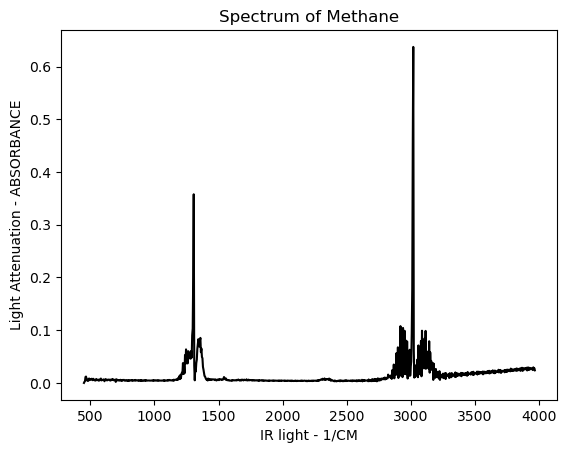

The first x-value in spec_dict for cas: 74828 is 450.0
The last x-value in spec_dict for cas: 74828 is 3966.0


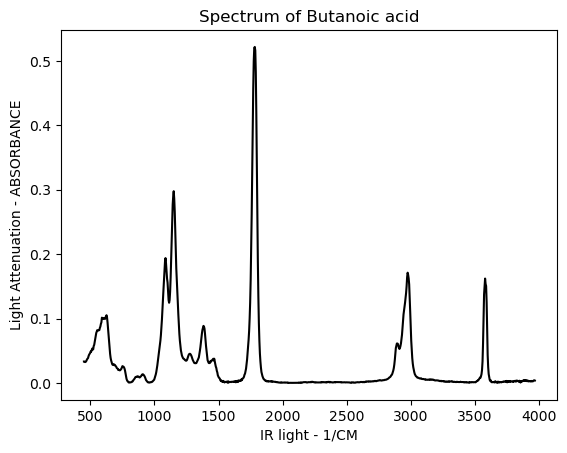

The first x-value in spec_dict for cas: 107926 is 450.0
The last x-value in spec_dict for cas: 107926 is 3966.0


In [39]:
# For the rest of the data points I'm going to need to interpolate to get the data most likely.
# Need to check to see if there are any points where I need extrapolation.

extrap = (df.loc[gas,'firstx'] > 549.8) | (df.loc[gas,'lastx'] < 4000.7)

cas = df.loc[gas & extrap, :].index[0] 
ind = spec_dict['cas'].index(cas)
plt.plot(spec_dict['x'][ind], spec_dict['y'][ind], color = 'black')
plt.xlabel('IR light - ' + df.loc[cas,'xunits'])
plt.ylabel('Light Attenuation - ' + df.loc[cas,'yunits'])
plt.title('Spectrum of ' + df.loc[cas,'title'])
plt.show()
print('The first x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][0])
print('The last x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][-1])

cas = df.loc[gas & extrap, :].index[1] 
ind = spec_dict['cas'].index(cas)
plt.plot(spec_dict['x'][ind], spec_dict['y'][ind], color = 'black')
plt.xlabel('IR light - ' + df.loc[cas,'xunits'])
plt.ylabel('Light Attenuation - ' + df.loc[cas,'yunits'])
plt.title('Spectrum of ' + df.loc[cas,'title'])
plt.show()
print('The first x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][0])
print('The last x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][-1])

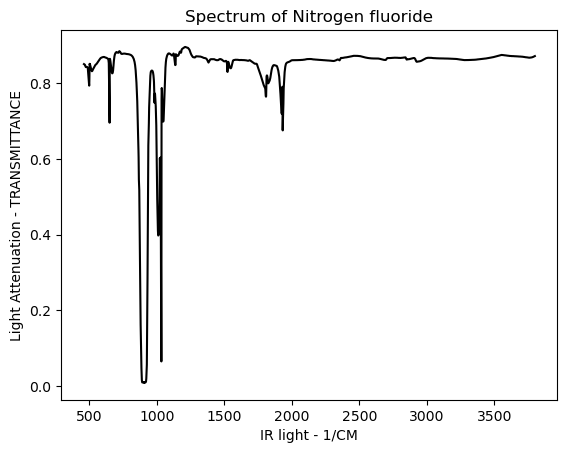

The first x-value in spec_dict for cas: 7783542 is 459.0
The last x-value in spec_dict for cas: 7783542 is 3800.0


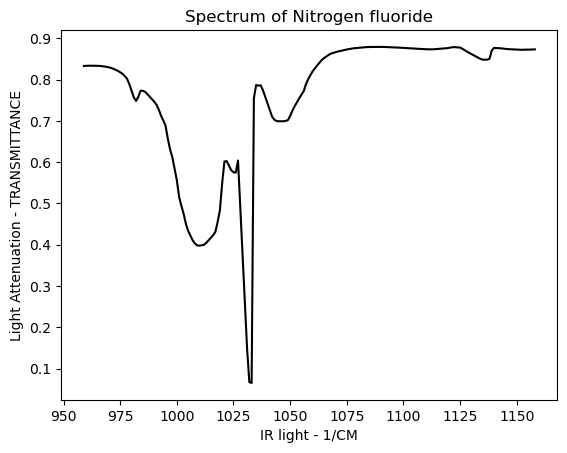

The first x-value in spec_dict for cas: 7783542 is 459.0
The last x-value in spec_dict for cas: 7783542 is 3800.0


In [40]:
# OK now lets look at some of the other types of spectra as well.

# one of the other types has a deltax of 1 cm-1
one = df.loc[gas,'deltax'] == 1

cas = df.loc[gas & one, :].index[0] 
ind = spec_dict['cas'].index(cas)
plt.plot(spec_dict['x'][ind], spec_dict['y'][ind], color = 'black')
plt.xlabel('IR light - ' + df.loc[cas,'xunits'])
plt.ylabel('Light Attenuation - ' + df.loc[cas,'yunits'])
plt.title('Spectrum of ' + df.loc[cas,'title'])
plt.show()
print('The first x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][0])
print('The last x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][-1])

zstrt = 500
zend = 700
cas = df.loc[gas & one, :].index[0] 
ind = spec_dict['cas'].index(cas)
plt.plot(spec_dict['x'][ind][zstrt:zend], spec_dict['y'][ind][zstrt:zend], color = 'black')
plt.xlabel('IR light - ' + df.loc[cas,'xunits'])
plt.ylabel('Light Attenuation - ' + df.loc[cas,'yunits'])
plt.title('Spectrum of ' + df.loc[cas,'title'])
plt.show()
print('The first x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][0])
print('The last x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][-1])

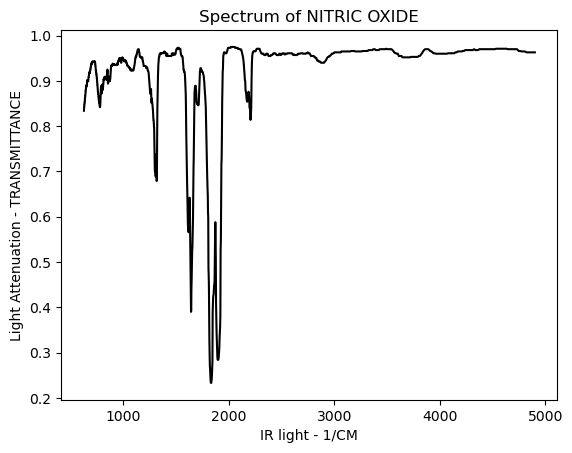

The first x-value in spec_dict for cas: 10102439 is 625.7313234843224
The last x-value in spec_dict for cas: 10102439 is 4901.9607843137255


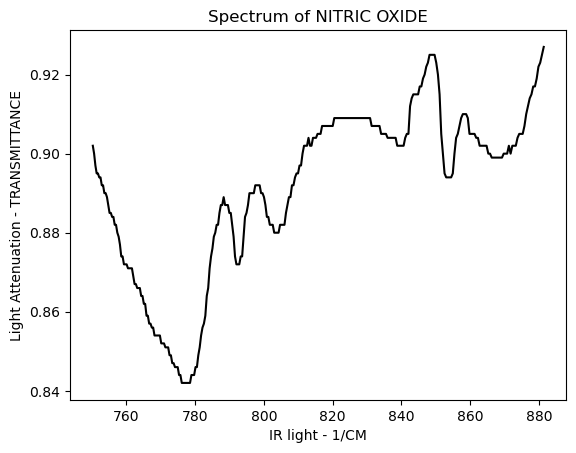

The first x-value in spec_dict for cas: 10102439 is 625.7313234843224
The last x-value in spec_dict for cas: 10102439 is 4901.9607843137255


In [41]:
# Also still have all of the ones converted from wavelength

cas = df.loc[gas & microm, :].index[0] 
ind = spec_dict['cas'].index(cas)
plt.plot(spec_dict['x'][ind], spec_dict['y'][ind], color = 'black')
plt.xlabel('IR light - ' + df.loc[cas,'xunits'])
plt.ylabel('Light Attenuation - ' + df.loc[cas,'yunits'])
plt.title('Spectrum of ' + df.loc[cas,'title'])
plt.show()
print('The first x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][0])
print('The last x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][-1])

zstrt = 400
zend = 700
cas = df.loc[gas & microm, :].index[0] 
ind = spec_dict['cas'].index(cas)
plt.plot(spec_dict['x'][ind][zstrt:zend], spec_dict['y'][ind][zstrt:zend], color = 'black')
plt.xlabel('IR light - ' + df.loc[cas,'xunits'])
plt.ylabel('Light Attenuation - ' + df.loc[cas,'yunits'])
plt.title('Spectrum of ' + df.loc[cas,'title'])
plt.show()
print('The first x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][0])
print('The last x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][-1])

In [42]:
# Hmmm what to do with these lots of things you could imagine doing.  Think I will
# just average the last five data points to replace the missing data points.
# Best would probably be fitting the baseline and using that for extrapolation.
# Could get really fancy and regress the current value to the baseline.

# Now it's time for some interpolation with the gold_x vector above.
# Looks like our range will go from 550 - 3846 as the most common range for deltax of 2 cm-1

#Saving a copy in case I need to revert for testing
tmp_spec_dict = spec_dict

gold_range = (df.loc[gas,'deltax'] == 1.928980) & (df.loc[gas,'firstx'] == 549.8) & (df.loc[gas,'lastx'] == 4000.7)
print('This many spectra already have this x-axis:',sum(gold_range))

cas = df.loc[gas & gold_range,:].index[0]
ind = spec_dict['cas'].index(cas)
gold_x = spec_dict['x'][ind]
print('This is the deltax:', df.loc[cas,'deltax'])

print(gold_x)

for cas in df.loc[gas & ~gold_range,:].index:
    
    # Generate function to interpolate
    ind = spec_dict['cas'].index(cas)
    f = interpolate.interp1d(spec_dict['x'][ind], spec_dict['y'][ind], 
        kind = 'linear', bounds_error = False, 
        fill_value = (np.mean(spec_dict['y'][ind][0:10]),np.mean(spec_dict['y'][ind][-10:-1])))
    
    # Alter spectra with interpolation
    spec_dict['x'][ind] = gold_x
    spec_dict['y'][ind] = f(gold_x)
    
    # Alter meta data
    df.loc[cas,'firstx'] = gold_x[0]
    df.loc[cas,'lastx'] = gold_x[-1]
    df.loc[cas,'maxx'] = gold_x[spec_dict['y'][ind].argmax()]
    df.loc[cas,'minx'] = gold_x[spec_dict['y'][ind].argmin()]
    df.loc[cas,'deltax'] = 1.928980
        

This many spectra already have this x-axis: 2220
This is the deltax: 1.92898
[ 549.759  551.688  553.617 ... 3996.842 3998.771 4000.7  ]


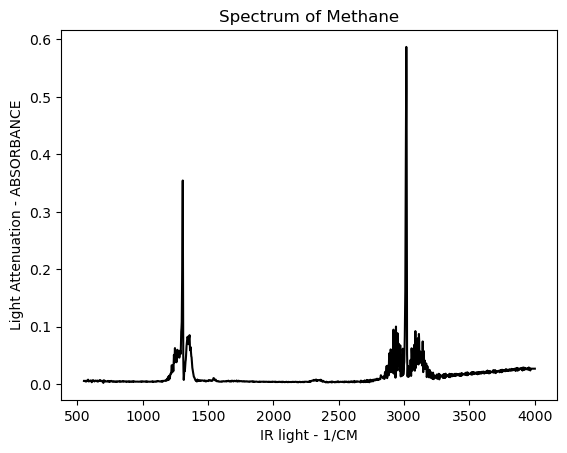

The first x-value in spec_dict for cas: 74828 is 549.759
The last x-value in spec_dict for cas: 74828 is 4000.7


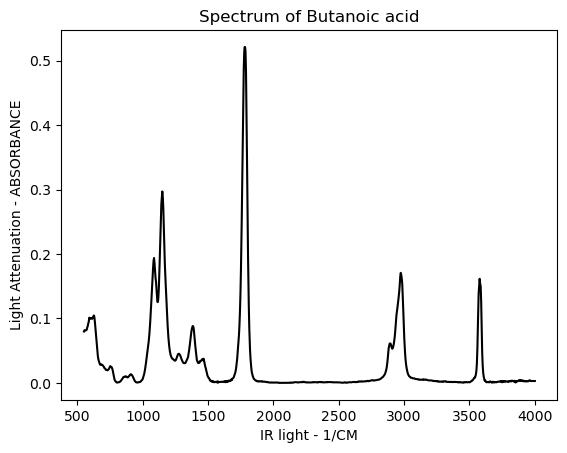

The first x-value in spec_dict for cas: 107926 is 549.759
The last x-value in spec_dict for cas: 107926 is 4000.7


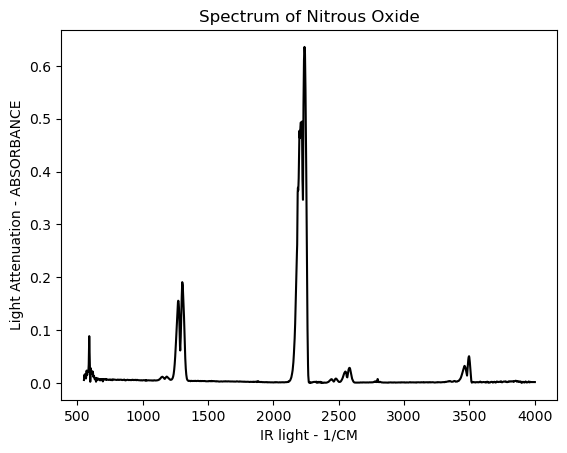

The first x-value in spec_dict for cas: 10024972 is 549.759
The last x-value in spec_dict for cas: 10024972 is 4000.7


In [43]:
# Know from previous method of analysis that deltax of four has some wider range
# spectra.  Need to pull these in order to see how the transformation impacts
# them and how much information we're losing.
# Very briefly let's get a look at what we'll be losing before a transformation

cas = df.loc[gas & wide_range, :].index[0] 
ind = spec_dict['cas'].index(cas)
plt.plot(spec_dict['x'][ind], spec_dict['y'][ind], color = 'black')
plt.xlabel('IR light - ' + df.loc[cas,'xunits'])
plt.ylabel('Light Attenuation - ' + df.loc[cas,'yunits'])
plt.title('Spectrum of ' + df.loc[cas,'title'])
plt.show()
print('The first x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][0])
print('The last x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][-1])

cas = df.loc[gas & wide_range, :].index[1] 
ind = spec_dict['cas'].index(cas)
plt.plot(spec_dict['x'][ind], spec_dict['y'][ind], color = 'black')
plt.xlabel('IR light - ' + df.loc[cas,'xunits'])
plt.ylabel('Light Attenuation - ' + df.loc[cas,'yunits'])
plt.title('Spectrum of ' + df.loc[cas,'title'])
plt.show()
print('The first x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][0])
print('The last x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][-1])

cas = df.loc[gas & wide_range, :].index[2] 
ind = spec_dict['cas'].index(cas)
plt.plot(spec_dict['x'][ind], spec_dict['y'][ind], color = 'black')
plt.xlabel('IR light - ' + df.loc[cas,'xunits'])
plt.ylabel('Light Attenuation - ' + df.loc[cas,'yunits'])
plt.title('Spectrum of ' + df.loc[cas,'title'])
plt.show()
print('The first x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][0])
print('The last x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][-1])

In [44]:
# Did I convert all of these to one deltax? Yes!

df.loc[gas,'deltax'].value_counts()

1.92898    8239
Name: deltax, dtype: int64

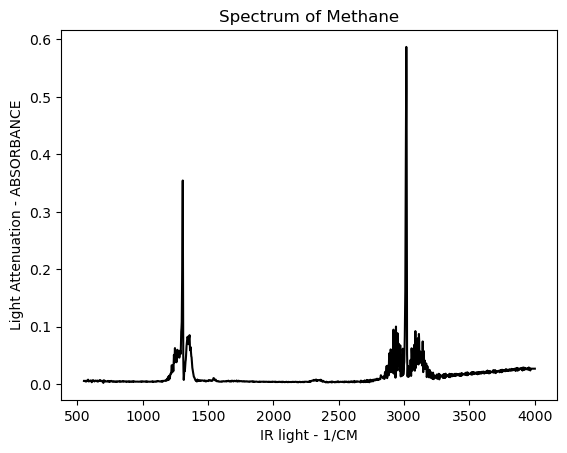

The first x-value in spec_dict for cas: 74828 is 549.759
The last x-value in spec_dict for cas: 74828 is 4000.7


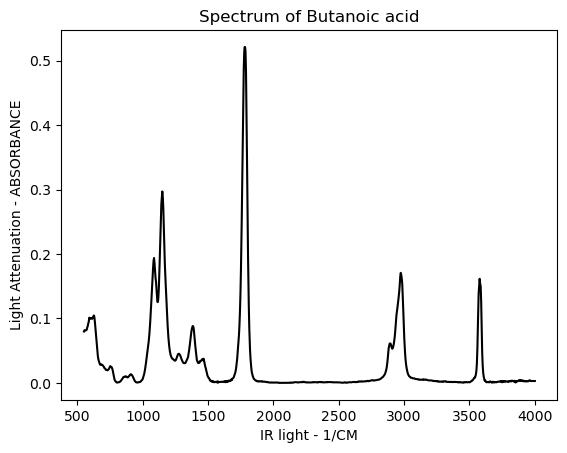

The first x-value in spec_dict for cas: 107926 is 549.759
The last x-value in spec_dict for cas: 107926 is 4000.7


In [45]:
# For the rest of the data points I'm going to need to interpolate to get the data most likely.
# Need to check to see if there are any points where I need extrapolation.

cas = df.loc[gas & extrap, :].index[0] 
ind = spec_dict['cas'].index(cas)
plt.plot(spec_dict['x'][ind], spec_dict['y'][ind], color = 'black')
plt.xlabel('IR light - ' + df.loc[cas,'xunits'])
plt.ylabel('Light Attenuation - ' + df.loc[cas,'yunits'])
plt.title('Spectrum of ' + df.loc[cas,'title'])
plt.show()
print('The first x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][0])
print('The last x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][-1])

cas = df.loc[gas & extrap, :].index[1] 
ind = spec_dict['cas'].index(cas)
plt.plot(spec_dict['x'][ind], spec_dict['y'][ind], color = 'black')
plt.xlabel('IR light - ' + df.loc[cas,'xunits'])
plt.ylabel('Light Attenuation - ' + df.loc[cas,'yunits'])
plt.title('Spectrum of ' + df.loc[cas,'title'])
plt.show()
print('The first x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][0])
print('The last x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][-1])

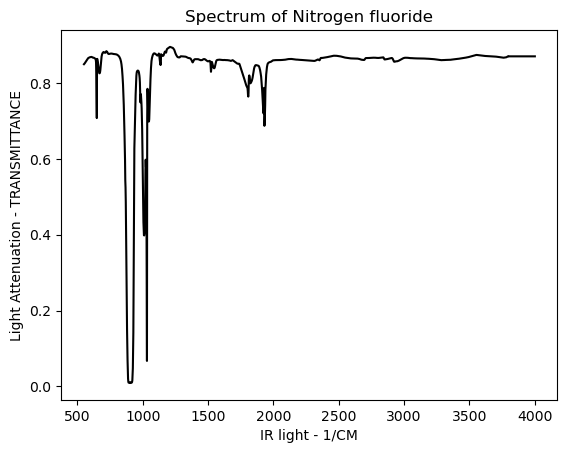

The first x-value in spec_dict for cas: 7783542 is 549.759
The last x-value in spec_dict for cas: 7783542 is 4000.7


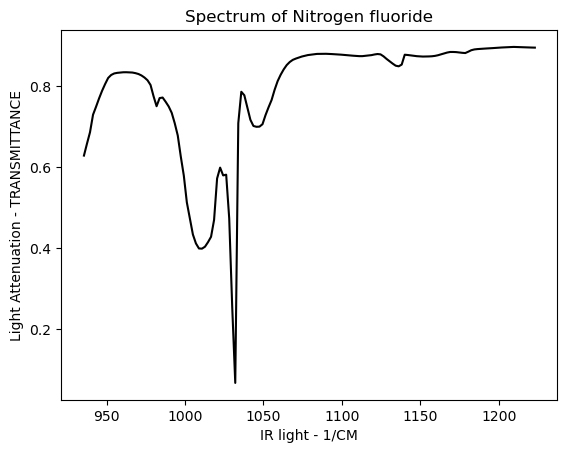

The first x-value in spec_dict for cas: 7783542 is 549.759
The last x-value in spec_dict for cas: 7783542 is 4000.7


In [46]:
# OK now lets look at some of the other types of spectra as well. - 1 cm-1 after conversion

cas = df.loc[gas & one, :].index[0] 
ind = spec_dict['cas'].index(cas)
plt.plot(spec_dict['x'][ind], spec_dict['y'][ind], color = 'black')
plt.xlabel('IR light - ' + df.loc[cas,'xunits'])
plt.ylabel('Light Attenuation - ' + df.loc[cas,'yunits'])
plt.title('Spectrum of ' + df.loc[cas,'title'])
plt.show()
print('The first x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][0])
print('The last x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][-1])

zstrt = 200
zend = 350
cas = df.loc[gas & one, :].index[0] 
ind = spec_dict['cas'].index(cas)
plt.plot(spec_dict['x'][ind][zstrt:zend], spec_dict['y'][ind][zstrt:zend], color = 'black')
plt.xlabel('IR light - ' + df.loc[cas,'xunits'])
plt.ylabel('Light Attenuation - ' + df.loc[cas,'yunits'])
plt.title('Spectrum of ' + df.loc[cas,'title'])
plt.show()
print('The first x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][0])
print('The last x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][-1])

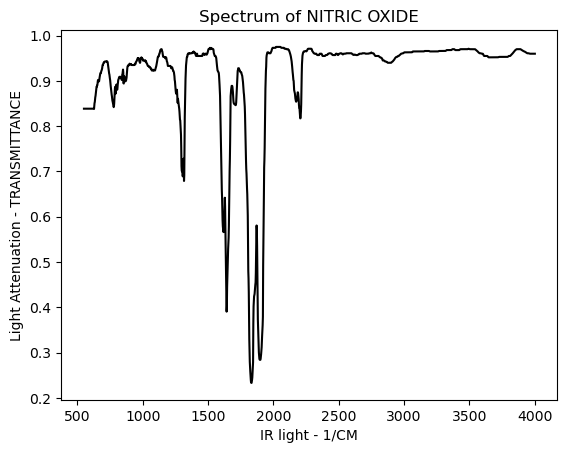

The first x-value in spec_dict for cas: 10102439 is 549.759
The last x-value in spec_dict for cas: 10102439 is 4000.7


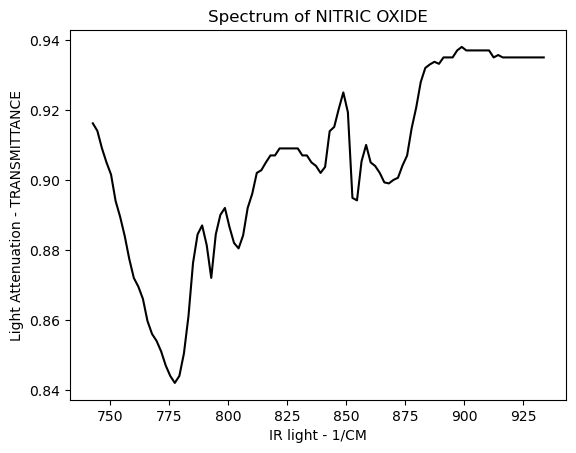

The first x-value in spec_dict for cas: 10102439 is 549.759
The last x-value in spec_dict for cas: 10102439 is 4000.7


In [47]:
# Also still have all of the ones converted from wavelength

cas = df.loc[gas & microm, :].index[0] 
ind = spec_dict['cas'].index(cas)
plt.plot(spec_dict['x'][ind], spec_dict['y'][ind], color = 'black')
plt.xlabel('IR light - ' + df.loc[cas,'xunits'])
plt.ylabel('Light Attenuation - ' + df.loc[cas,'yunits'])
plt.title('Spectrum of ' + df.loc[cas,'title'])
plt.show()
print('The first x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][0])
print('The last x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][-1])

zstrt = 100
zend = 200
cas = df.loc[gas & microm, :].index[0] 
ind = spec_dict['cas'].index(cas)
plt.plot(spec_dict['x'][ind][zstrt:zend], spec_dict['y'][ind][zstrt:zend], color = 'black')
plt.xlabel('IR light - ' + df.loc[cas,'xunits'])
plt.ylabel('Light Attenuation - ' + df.loc[cas,'yunits'])
plt.title('Spectrum of ' + df.loc[cas,'title'])
plt.show()
print('The first x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][0])
print('The last x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][-1])

In [48]:
df.loc[gas,'lastx'].value_counts()

4000.7    8239
Name: lastx, dtype: int64

In [49]:
df.loc[gas,'yunits'].value_counts()

ABSORBANCE                       8183
TRANSMITTANCE                      55
(micromol/mol)-1m-1 (base 10)       1
Name: yunits, dtype: int64

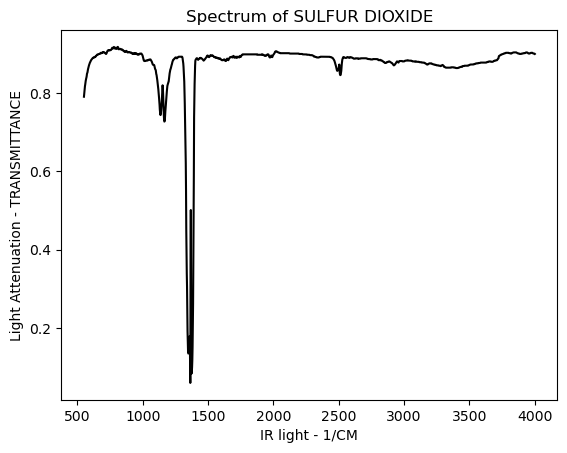

The first x-value in spec_dict for cas: 7446095 is 549.759
The last x-value in spec_dict for cas: 7446095 is 4000.7


In [50]:
# Still need to deal with yunits

trans = df.loc[gas,'yunits'] == 'TRANSMITTANCE'

cas = df.loc[gas & trans, :].index[0] 
ind = spec_dict['cas'].index(cas)
plt.plot(spec_dict['x'][ind], spec_dict['y'][ind], color = 'black')
plt.xlabel('IR light - ' + df.loc[cas,'xunits'])
plt.ylabel('Light Attenuation - ' + df.loc[cas,'yunits'])
plt.title('Spectrum of ' + df.loc[cas,'title'])
plt.show()
print('The first x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][0])
print('The last x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][-1])

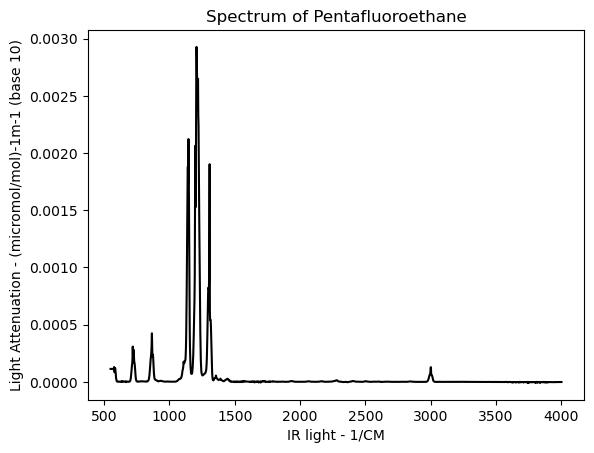

The first x-value in spec_dict for cas: 354336 is 549.759
The last x-value in spec_dict for cas: 354336 is 4000.7


In [51]:
# Check on the one extinction coefficient spectrum

ExtCoeff = (df.loc[gas,'yunits'] == '(micromol/mol)-1m-1 (base 10)')

cas = df.loc[gas & ExtCoeff, :].index[0] 
ind = spec_dict['cas'].index(cas)
plt.plot(spec_dict['x'][ind], spec_dict['y'][ind], color = 'black')
plt.xlabel('IR light - ' + df.loc[cas,'xunits'])
plt.ylabel('Light Attenuation - ' + df.loc[cas,'yunits'])
plt.title('Spectrum of ' + df.loc[cas,'title'])
plt.show()
print('The first x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][0])
print('The last x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][-1])


# Looks like I should be able to just treat as abosrbance when converting to transmittance (value not outrageously high
# at 10000 or something).  Data will be scaled at the end.

In [52]:
# Getting all absorbance converted

def yconv(absorbance):
    return ((10**(2 - absorbance))/100)

for cas in df.loc[gas & ~trans,:].index:
    ind = spec_dict['cas'].index(cas)
    spec_dict['y'][ind] = yconv(spec_dict['y'][ind])
    df.loc[cas,'yunits'] = 'TRANSMITTANCE'

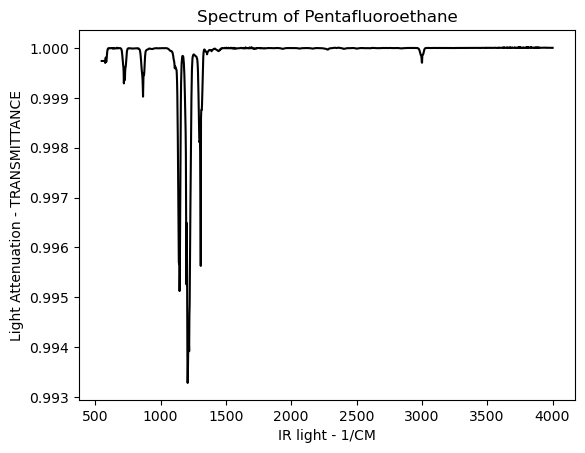

The first x-value in spec_dict for cas: 354336 is 549.759
The last x-value in spec_dict for cas: 354336 is 4000.7


In [53]:
# Checking spectrum after the conversion

cas = df.loc[gas & ExtCoeff, :].index[0] 
ind = spec_dict['cas'].index(cas)
plt.plot(spec_dict['x'][ind], spec_dict['y'][ind], color = 'black')
plt.xlabel('IR light - ' + df.loc[cas,'xunits'])
plt.ylabel('Light Attenuation - ' + df.loc[cas,'yunits'])
plt.title('Spectrum of ' + df.loc[cas,'title'])
plt.show()
print('The first x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][0])
print('The last x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][-1])

In [54]:
# Finally we are ready to get the gas FTIR dataframe!!!
    
gasmat = np.zeros((len(df.loc[gas,:].index), len(gold_x)))
#gasmat[0,:] = gold_x
i = 0

# Make array of all gas indices
for cas in df.loc[gas,:].index:
    ind = spec_dict['cas'].index(cas)
    if len(spec_dict['y'][ind]) != 1790:
        print('y') # error check to see all arrays same length
    if not(np.array_equal(gold_x, spec_dict['x'][ind])):
        print('x') #error check to see if all x = gold_x
    gasmat[i,:] = spec_dict['y'][ind]
    i += 1
    
df_gasspec = pd.DataFrame(gasmat, index = df.loc[gas,:].index)
    



In [55]:
df_gasspec.columns = gold_x

df_gasspec.head()

,549.759,551.688,553.617,555.546,557.475,559.404,561.333,563.262,565.191,567.120,...,3983.339,3985.268,3987.197,3989.126,3991.055,3992.984,3994.913,3996.842,3998.771,4000.700
cas,,,,,,,,,,,,,,,,,,,,,
74828,0.986918,0.987171,0.987171,0.986779,0.986290,0.987326,0.988934,0.988347,0.986600,0.986881,...,0.939590,0.939590,0.939590,0.939590,0.939590,0.939590,0.939590,0.939590,0.939590,0.939590
107926,0.832241,0.830296,0.828374,0.828493,0.829118,0.829253,0.829204,0.828842,0.828314,0.828037,...,0.993188,0.993188,0.993188,0.993188,0.993188,0.993188,0.993188,0.993188,0.993188,0.993188
7446095,0.790825,0.798153,0.804582,0.810960,0.817754,0.821717,0.827548,0.831356,0.834963,0.837808,...,0.902319,0.902000,0.901474,0.901000,0.901000,0.901000,0.901000,0.901000,0.900872,0.900149
10028156,1.008000,1.009185,1.010140,1.012000,1.016051,1.018000,1.018000,1.020916,1.022000,1.022827,...,0.625000,0.625000,0.625000,0.625000,0.625000,0.625000,0.625000,0.625000,0.625000,0.625000
10024972,0.987303,0.977039,0.964795,0.969127,0.977609,0.972179,0.961630,0.966931,0.980730,0.973313,...,0.996139,0.996139,0.996139,0.996139,0.996139,0.996139,0.996139,0.996139,0.996139,0.996139


# Data Cleaning for Gas Spectra Complete
# On to Initial EDA

In [58]:
# At first I converted everything to absorbance because most of the spectra were
# in absorbnce - however, some of the transmittance spectra have 0 transmittance
# which gives infinite absorbance.
# Switched over to transmittance and now the np.isinf() function shows no infinite

np.isinf(df_gasspec).any().any()

False

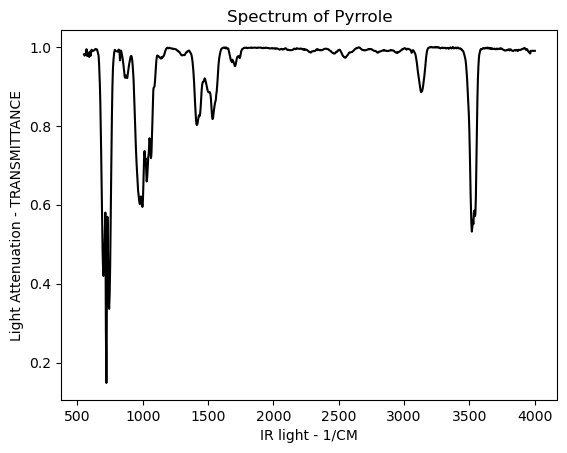

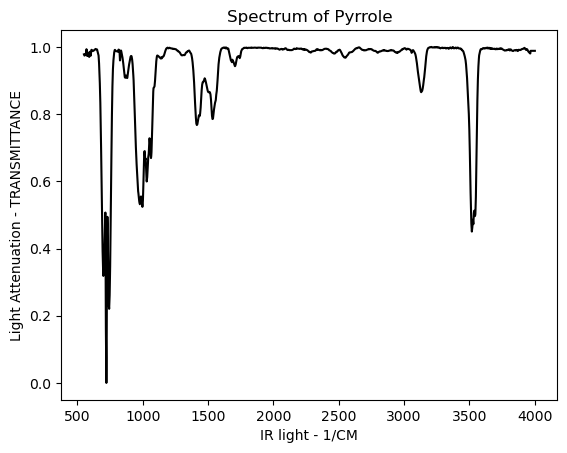

In [76]:
# Here I'm just using the MinMaxScaler() to scale the data

std = MinMaxScaler()
gasmat_std = np.transpose(std.fit_transform(np.transpose(gasmat)))

ind = 300
cas = df.loc[gas,:].index[ind]
plt.plot(gold_x,gasmat[ind,:], color='black')
plt.xlabel('IR light - ' + df.loc[cas,'xunits'])
plt.ylabel('Light Attenuation - ' + df.loc[cas,'yunits'])
plt.title('Spectrum of ' + df.loc[cas,'title'])
plt.show()

cas = df.loc[gas,:].index[ind]
plt.plot(gold_x,gasmat_std[ind,:], color='black')
plt.xlabel('IR light - ' + df.loc[cas,'xunits'])
plt.ylabel('Light Attenuation - ' + df.loc[cas,'yunits'])
plt.title('Spectrum of ' + df.loc[cas,'title'])
plt.show()

95.02581955823575


Text(0, 0.5, 'Cumulative Percent Variation Explained')

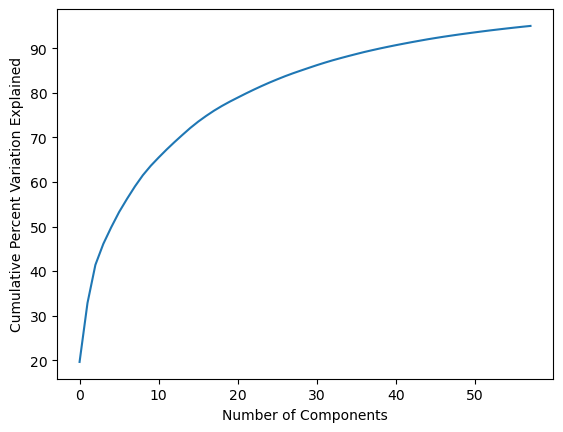

In [110]:
# Now do PCA to reduce the dimensionality

PC = PCA(n_components = 58)
gasmat_pca = PC.fit_transform(gasmat_std)

print(sum(PC.explained_variance_ratio_)*100)

plt.plot(np.cumsum(PC.explained_variance_ratio_*100))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Percent Variation Explained')

# Not Using these cells right now marked for deletion

In [ ]:
def scrape_inchi(cas_ls, params, data_dir):
	'''Collect Inchi keys from NIST database and store them in txt format.
    Args:
        cas_ls: (list) CAS ids to download data for
		params: (dict) queries to be added to url
		data_dir: (string) path to store the data
    Returns:
        None
    '''	

	#Create file path for storing inchi keys
	inchi_path = os.path.join(data_dir, 'inchi.txt')
	num_created = 0
	with open(inchi_path,'a') as file:
		content = '{}\t{}\n'.format('cas_id', 'inchi')
		file.write(content)

		for cas_id in cas_ls:
			params['GetInChI'] = 'C' + cas_id
			response = requests.get(nist_url, params=params)

			num_created+=1
			logging.info('Creating InChi key for id: {}. Total keys created {}'.format(cas_id, num_created))
			content = '{}\t{}\n'.format(cas_id,response.content.decode("utf-8"))
			file.write(content)

In [ ]:
# All code to used if you're running this from the command line.
# I'm trying to run this in a Jupyter notebook.

#parser = argparse.ArgumentParser()
#parser.add_argument('--save_dir', default= './data',\
#     help = "Directory path to store scrapped data")
#parser.add_argument('--cas_list', default= 'species.txt',\
#    help = "File containing CAS number and formula of molecules")
#parser.add_argument('--scrape_IR', default= True,\
#    help = "Whether to download IR or not")
#parser.add_argument('--scrape_InChi', default= True,\
#    help = "Whether to download InChi or not")

In [ ]:
# Command line stuff
#args = parser.parse_args()

cas_list = 'species.txt'

#Check if file containing CAS ids exist
assert os.path.isfile(cas_list),"No file named {} exists".format(cas_list)

# Removing this until I figure out how to bring in models.util
#set_logger(data_dir, 'scrape.log')

In [ ]:
meta_dict['cas'].append(cas)

In [ ]:
# Setting the dict that I'll be adding all of the spectra to

spec_dict = {'cas':[], 'x':[], 'y':[]}
spec_dict['cas'].append(str(cas))
spec_dict['x'].append(data['x'])
spec_dict['y'].append(data['y'])

print(spec_dict)

# Then I will drop the spectra from the jcamp dict

del data['x']
del data['y']

specmeta = pd.DataFrame(data, index = [str(cas)])

In [ ]:
# Going to drop these columns from the gas df.  Many of the columns were missing 6000 or greater data points so I
# dropped all of those columns

df_gas = df.loc[gas,:]

col_drop = (df_gas.isna().sum() > 6000).tolist()

df_gas = df_gas.drop(labels = df_gas.loc[:,col_drop].columns.tolist(), axis = 1)

In [ ]:
# Now the easier part of this transformation

for cas in df.loc[gas & four & ~gold_range, :].index:
    
    # First update trim the spectra
    ind = spec_dict['cas'].index(cas)
    keep = (548 < spec_dict['x'][ind]) & (spec_dict['x'][ind] < 3848)
    spec_dict['x'][ind] = spec_dict['x'][ind][keep]
    spec_dict['y'][ind] = spec_dict['y'][ind][keep]
    
    # Next update the first and lastx meta data
    df.loc[cas, 'firstx'] = spec_dict['x'][ind][0]
    df.loc[cas, 'lastx'] = spec_dict['x'][ind][-1]

In [ ]:
# and here's the spectra after the trim

cas = df.loc[gas & four & ~gold_range, :].index[0] 
ind = spec_dict['cas'].index(cas)
plt.plot(spec_dict['x'][ind], spec_dict['y'][ind], color = 'black')
plt.xlabel('IR light - ' + df.loc[cas,'xunits'])
plt.ylabel('Light Attenuation - ' + df.loc[cas,'yunits'])
plt.title('Spectrum of ' + df.loc[cas,'title'])
plt.show()
print('The first x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][0])
print('The last x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][-1])

cas = df.loc[gas & four & ~gold_range, :].index[1] 
ind = spec_dict['cas'].index(cas)
plt.plot(spec_dict['x'][ind], spec_dict['y'][ind], color = 'black')
plt.xlabel('IR light - ' + df.loc[cas,'xunits'])
plt.ylabel('Light Attenuation - ' + df.loc[cas,'yunits'])
plt.title('Spectrum of ' + df.loc[cas,'title'])
plt.show()
print('The first x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][0])
print('The last x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][-1])

cas = df.loc[gas & four & ~gold_range, :].index[2] 
ind = spec_dict['cas'].index(cas)
plt.plot(spec_dict['x'][ind], spec_dict['y'][ind], color = 'black')
plt.xlabel('IR light - ' + df.loc[cas,'xunits'])
plt.ylabel('Light Attenuation - ' + df.loc[cas,'yunits'])
plt.title('Spectrum of ' + df.loc[cas,'title'])
plt.show()
print('The first x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][0])
print('The last x-value in spec_dict for cas:',cas,'is',spec_dict['x'][ind][-1])